### Проект Маркетинг

**Цель исследования:**  
Наш проект направлен на прогнозирование вероятности совершения покупки клиентом интернет-магазина в течение следующих 90 дней. Это поможет маркетинговой команде оптимизировать рекламные рассылки и повысить эффективность будущих кампаний.  

**Данные:**  
В работе используются три основных набора данных:  
1. **История покупок (`apparel-purchases`)** — информация о заказах клиентов, включая количество товаров, их цену, категории и даты покупок.  
2. **История рассылок (`apparel-messages`)** — данные о рекламных кампаниях: каналы рассылки, типы событий, даты отправки.  
3. **Целевой признак (`apparel-target_binary`)** — метки, указывающие, совершил ли клиент покупку в течение 90 дней после последней активности.  

**Задачи:**  
- Анализ и предобработка данных.  
- Генерация полезных признаков для прогнозирования.  
- Построение и оптимизация модели классификации с фокусом на метрику ROC-AUC.  
- Тестирование модели и оценка её эффективности.  

**Результат:**  
Готовое решение включает Jupyter-тетрадку с исследованием, README с описанием проекта и файл зависимостей. Код будет размещён в открытом репозитории на GitHub.  

Далее перейдём к изучению данных и подготовке признаков.

## Загрузка библиотек

In [1]:
!pip install missingno -q

In [2]:
import os
import math
import hashlib
from collections import Counter

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import phik
from phik.report import plot_correlation_matrix

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.stats import loguniform

## Загрузка данных

In [3]:
apparel_purchases = pd.read_csv('filtered_data/apparel-purchases.csv')
display(apparel_purchases.info())
display(apparel_purchases.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [4]:
apparel_messages = pd.read_csv('filtered_data/apparel-messages.csv')
display(apparel_messages.info())
display(apparel_messages.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [5]:
apparel_target_binary = pd.read_csv('filtered_data/apparel-target_binary.csv')
display(apparel_target_binary.info())
display(apparel_target_binary.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


### Анализируем загруженные данные

In [6]:
def dataset_overview(df, name='Dataset'):
    """Выводит основную информацию о датафрейме"""
    print(f"═{'═'*50}")
    print(f"ОБЗОР ДАТАСЕТА: {name.upper()}")
    print(f"═{'═'*50}")

    print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")

    print("\nСтруктура данных:")
    info_df = pd.DataFrame({
        'Тип данных': df.dtypes,
        'Уникальных значений': df.nunique(),
        'Пропуски': df.isna().sum(),
        '% Пропусков': round(df.isna().mean() * 100, 2)
    })
    display(info_df)

    num_cols = df.select_dtypes(include=['number']).columns
    if len(num_cols) > 0:
        print("\nОписательная статистика числовых столбцов:")
        display(df[num_cols].describe().T.round(2))

    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nКатегориальные столбцы (первые 5 значений):")
        for col in cat_cols:
            print(f"\n{col}:")
            print(df[col].value_counts().head())
    
    print(f"\n{'═'*60}")

In [7]:
dataset_overview(apparel_purchases, 'Apparel Purchases')

═══════════════════════════════════════════════════
ОБЗОР ДАТАСЕТА: APPAREL PURCHASES
═══════════════════════════════════════════════════
Размер данных: 202208 строк, 6 столбцов

Структура данных:


,Тип данных,Уникальных значений,Пропуски,% Пропусков
client_id,int64,49849,0,0.0
quantity,int64,16,0,0.0
price,float64,3642,0,0.0
category_ids,object,933,0,0.0
date,object,642,0,0.0
message_id,object,50204,0,0.0



Описательная статистика числовых столбцов:


,count,mean,std,min,25%,50%,75%,max
client_id,202208.0,1.515916e+18,1.459458e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
quantity,202208.0,1.010000e+00,1.800000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01
price,202208.0,1.193300e+03,1.342250e+03,1.000000e+00,3.520000e+02,9.870000e+02,1.699000e+03,8.549900e+04



Категориальные столбцы (первые 5 значений):

category_ids:
['4', '28', '57', '431']     8626
['4', '28', '260', '420']    6989
['4', '28', '244', '432']    6821
[]                           5579
['4', '28', '275', '421']    4936
Name: category_ids, dtype: int64

date:
2022-11-11    5270
2023-06-10    3836
2023-04-28    3473
2022-11-15    2937
2022-12-22    2631
Name: date, dtype: int64

message_id:
1515915625489095763-6251-6311b13a4cf78     365
1515915625624308268-7803-636dfea7ca890     218
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
1515915625558691508-14212-6567128370bdd    143
Name: message_id, dtype: int64

════════════════════════════════════════════════════════════


Данные содержат 202 тыс. записей о покупках одежды без пропущенных значений. Большинство заказов - единичные товары (медиана количества = 1), хотя встречаются и оптовые покупки до 30 штук. 

Цены показывают сильный разброс: при среднем чеке 1 193 рубля медиана составляет всего 987 рублей, что указывает на влияние дорогих покупок, включая экстремальные значения до 85 499 рублей. 

Наиболее популярные категории товаров начинаются с ID 4 и 28, а пик продаж пришелся на 11 ноября 2022 года (5 270 заказов), что вероятно связано с распродажами.

In [8]:
dataset_overview(apparel_messages, 'Apparel Massages')

═══════════════════════════════════════════════════
ОБЗОР ДАТАСЕТА: APPAREL MASSAGES
═══════════════════════════════════════════════════
Размер данных: 12739798 строк, 7 столбцов

Структура данных:


,Тип данных,Уникальных значений,Пропуски,% Пропусков
bulk_campaign_id,int64,2709,0,0.0
client_id,int64,53329,0,0.0
message_id,object,9061667,0,0.0
event,object,11,0,0.0
channel,object,2,0,0.0
date,object,638,0,0.0
created_at,object,4103539,0,0.0



Описательная статистика числовых столбцов:


,count,mean,std,min,25%,50%,75%,max
bulk_campaign_id,12739798.0,1.160459e+04,3.259210e+03,5.480000e+02,8.746000e+03,1.351600e+04,1.415800e+04,1.465700e+04
client_id,12739798.0,1.515916e+18,1.329704e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18



Категориальные столбцы (первые 5 значений):

message_id:
1515915625489095763-6251-6311b13a4cf78    1454
1515915625490241385-6973-633edf70723d8     438
1515915625490540122-6973-633edf707840d     438
1515915625629509124-6374-63241bd1541d5     293
1515915625488270582-3433-6232d6007e929     254
Name: message_id, dtype: int64

event:
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
Name: event, dtype: int64

channel:
mobile_push    7512156
email          5227642
Name: channel, dtype: int64

date:
2023-06-10    89661
2024-01-26    84619
2023-12-11    83042
2023-12-10    81734
2023-12-26    80376
Name: date, dtype: int64

created_at:
2023-12-29 15:20:53    621
2023-07-03 10:22:53    573
2023-12-29 14:51:53    485
2023-12-29 14:51:33    483
2023-12-29 15:20:13    476
Name: created_at, dtype: int64

════════════════════════════════════════════════════════════


Датасет содержит 12.7 млн сообщений клиентам без пропусков данных. 

Большинство событий — это отправки сообщений (9 млн), открытия (3 млн) и клики (496 тыс.), причем мобильные push-уведомления преобладают над email (7.5 млн против 5.2 млн). 

Активность неравномерна — пики приходятся на декабрь 2023 и январь 2024 года, с максимальной активностью 89 тыс. сообщений. Особый интерес представляют 62 тыс. событий покупок и 19 тыс. "жестких отказов" (hard_bounce).

In [9]:
dataset_overview(apparel_target_binary, 'Apparel Target Binary')

═══════════════════════════════════════════════════
ОБЗОР ДАТАСЕТА: APPAREL TARGET BINARY
═══════════════════════════════════════════════════
Размер данных: 49849 строк, 2 столбцов

Структура данных:


,Тип данных,Уникальных значений,Пропуски,% Пропусков
client_id,int64,49849,0,0.0
target,int64,2,0,0.0



Описательная статистика числовых столбцов:


,count,mean,std,min,25%,50%,75%,max
client_id,49849.0,1.515916e+18,1.487947e+08,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18,1.515916e+18
target,49849.0,2.000000e-02,1.400000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00



════════════════════════════════════════════════════════════


Датасет содержит 49 849 бинарных целевых значений (0 или 1) без пропусков. 

Распределение сильно несбалансированное: только 2% наблюдений относятся к положительному классу. 

## Объединим три таблицы

In [10]:
merged_data = pd.merge(
    apparel_messages,
    apparel_purchases,
    on=['client_id', 'message_id'],
    how='inner',
    suffixes=('_purchase', '_message')
)

final_tree_table = pd.merge(
    merged_data,
    apparel_target_binary,
    on='client_id',
    how='inner'
)

print(f"Размер итоговой таблицы: {final_tree_table.shape}")
print("\nСтолбцы в финальной таблице:")
print(final_tree_table.columns.tolist())
print("\nПропуски в данных:")
print(final_tree_table.isnull().sum())

Размер итоговой таблицы: (805820, 12)

Столбцы в финальной таблице:
['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel', 'date_purchase', 'created_at', 'quantity', 'price', 'category_ids', 'date_message', 'target']

Пропуски в данных:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date_purchase       0
created_at          0
quantity            0
price               0
category_ids        0
date_message        0
target              0
dtype: int64


### Произведем анализ и предобработку

Проверим типы данных

In [11]:
final_tree_table.dtypes

bulk_campaign_id      int64
client_id             int64
message_id           object
event                object
channel              object
date_purchase        object
created_at           object
quantity              int64
price               float64
category_ids         object
date_message         object
target                int64
dtype: object

Приведем столбцы к временному типу 

In [12]:
final_tree_table['date_purchase'] = pd.to_datetime(final_tree_table['date_purchase'],format='%Y-%m-%d')
final_tree_table['date_message'] = pd.to_datetime(final_tree_table['date_message'],format='%Y-%m-%d')
final_tree_table['created_at'] = pd.to_datetime(final_tree_table['created_at'],format='%Y-%m-%d %H:%M:%S')
final_tree_table.dtypes

bulk_campaign_id             int64
client_id                    int64
message_id                  object
event                       object
channel                     object
date_purchase       datetime64[ns]
created_at          datetime64[ns]
quantity                     int64
price                      float64
category_ids                object
date_message        datetime64[ns]
target                       int64
dtype: object

Рассмотрим аномалии в столбцах цены и количества

Анализ аномалий в столбцах: ['price', 'quantity']


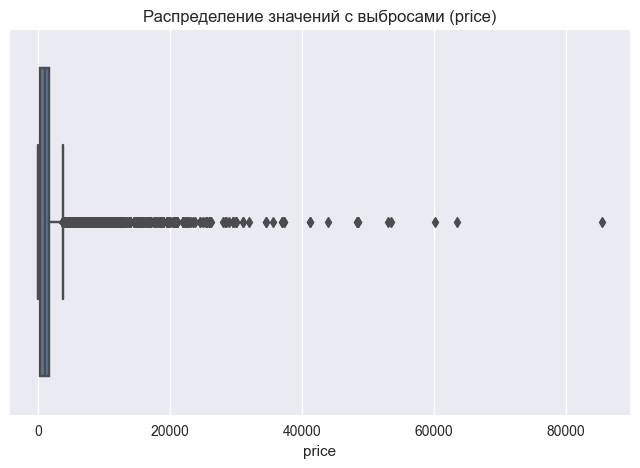


Статистика по 'price':
- Границы выбросов: [-1551.00, 3649.00]
- Количество выбросов: 26874 (3.33%)
- Минимальное значение: 1.0
- 1-й квартиль (Q1): 399.0
- Медиана: 999.0
- 3-й квартиль (Q3): 1699.0
- Максимальное значение: 85499.0


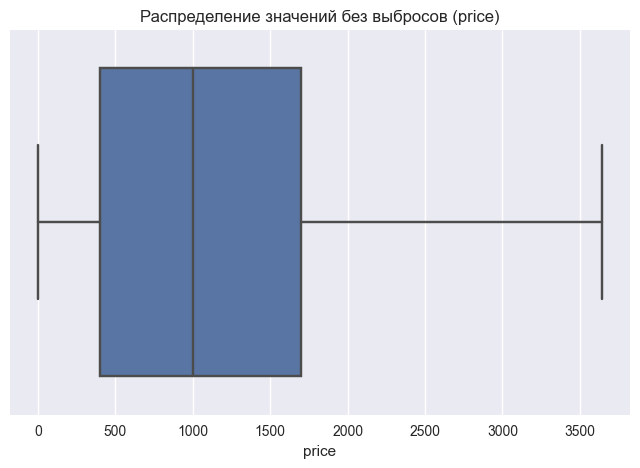

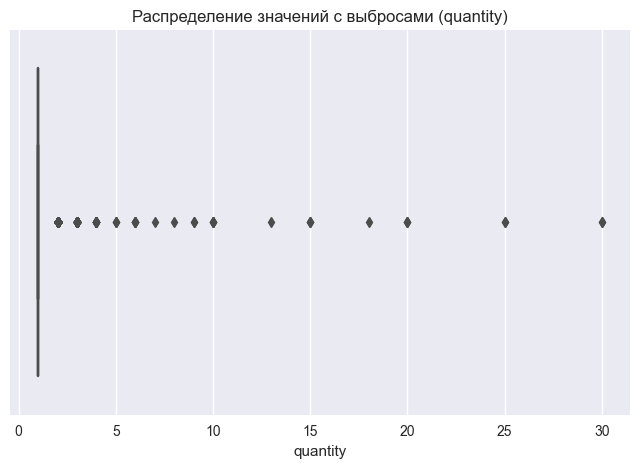


Статистика по 'quantity':
- Границы выбросов: [1.00, 1.00]
- Количество выбросов: 4237 (0.53%)
- Минимальное значение: 1
- 1-й квартиль (Q1): 1.0
- Медиана: 1.0
- 3-й квартиль (Q3): 1.0
- Максимальное значение: 30


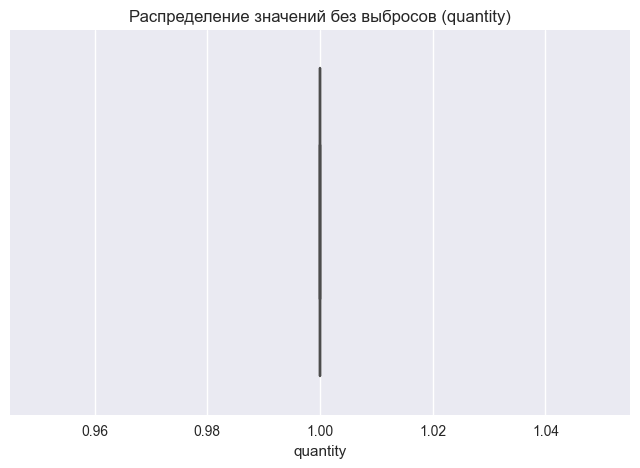

In [13]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 6)

numeric_cols = ['price', 'quantity']
print(f"Анализ аномалий в столбцах: {numeric_cols}")

for col in numeric_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=apparel_purchases[col])
    plt.title(f'Распределение значений с выбросами ({col})')
    plt.xlabel(col)
    plt.show()

    q1 = final_tree_table[col].quantile(0.25)
    q3 = final_tree_table[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = final_tree_table[(final_tree_table[col] < lower_bound) | (final_tree_table[col] > upper_bound)]
    print(f"\nСтатистика по '{col}':")
    print(f"- Границы выбросов: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"- Количество выбросов: {len(outliers)} ({len(outliers)/len(final_tree_table):.2%})")
    print(f"- Минимальное значение: {final_tree_table[col].min()}")
    print(f"- 1-й квартиль (Q1): {q1}")
    print(f"- Медиана: {final_tree_table[col].median()}")
    print(f"- 3-й квартиль (Q3): {q3}")
    print(f"- Максимальное значение: {final_tree_table[col].max()}")
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=final_tree_table[col], showfliers=False)
    plt.title(f'Распределение значений без выбросов ({col})')
    plt.xlabel(col)
    plt.show()

Удалим аномалии

In [14]:
print(f"Строк до очистки: {final_tree_table.shape[0]}")

Строк до очистки: 805820


Удилим только строки, где цена больше 70000

In [15]:
final_tree_table = final_tree_table[final_tree_table['price'] < 70000]
print(f"Строк после очистки: {final_tree_table.shape[0]}")

Строк после очистки: 805816


Удалилось всего 4 строки

## Добавление полезных признаков

**Добавим столбец с общей стоимостью**

In [16]:
final_tree_table['total_price'] = final_tree_table['price'] * final_tree_table['quantity']

Рассмотрим столбец category_ids

In [17]:
display(final_tree_table['category_ids'].sample(10))

773522         ['4', '31', '324', '1431']
725015        ['2', '17', '1826', '1818']
201396          ['2', '18', '212', '726']
445322                                 []
615711    ['5562', '5631', '5549', '667']
491521          ['4', '28', '156', '416']
722479    ['5562', '5633', '5600', '634']
558122           ['4', '28', '57', '431']
153056          ['4', '28', '124', '415']
776569          ['4', '28', '260', '420']
Name: category_ids, dtype: object

Приведем его к листу и рассмотрим глубину вложенности

In [18]:
final_tree_table['category_list'] = final_tree_table['category_ids'].str.strip('[]').str.replace("'", "").str.split(', ')

print("Максимальная вложенность:", final_tree_table['category_list'].apply(len).max())
print("Минимальная вложенность:", final_tree_table['category_list'].apply(len).min())
print("Пустые списки:", final_tree_table['category_list'].apply(len).eq(0).sum())

Максимальная вложенность: 5
Минимальная вложенность: 1
Пустые списки: 0


### Анализ топовых категорий

In [19]:
all_categories = []
for lst in final_tree_table['category_list']:
    all_categories.extend(lst)

top_categories = Counter(all_categories).most_common(20)
print("Топ-20 категорий:")
for cat, count in top_categories:
    print(f"{cat}: {count} ({count/len(final_tree_table):.1%})")

Топ-20 категорий:
4: 450589 (55.9%)
28: 328761 (40.8%)
5562: 187418 (23.3%)
2: 115818 (14.4%)
18: 103865 (12.9%)
27: 48708 (6.0%)
57: 37960 (4.7%)
431: 37960 (4.7%)
260: 37426 (4.6%)
5630: 37397 (4.6%)
5631: 34202 (4.2%)
275: 33795 (4.2%)
62: 33332 (4.1%)
31: 32906 (4.1%)
258: 30487 (3.8%)
420: 30206 (3.7%)
244: 28547 (3.5%)
432: 28547 (3.5%)
6060: 24067 (3.0%)
5589: 23593 (2.9%)


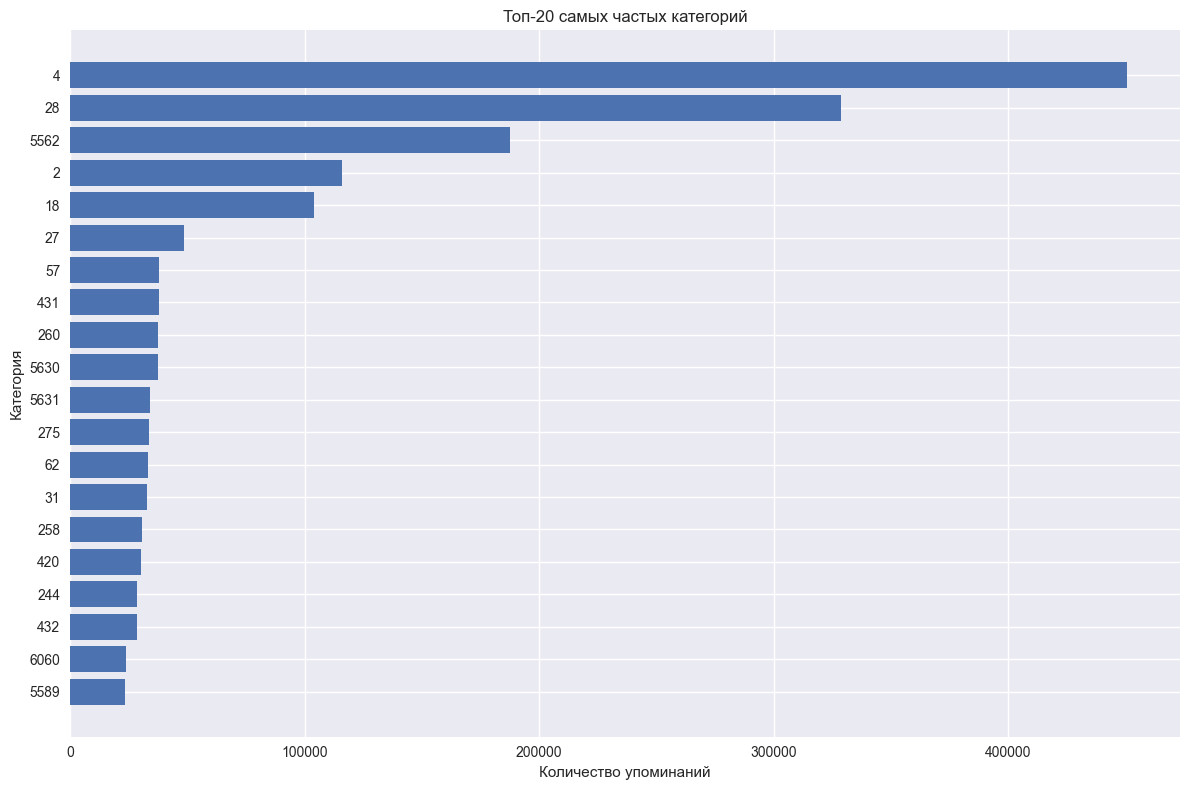

In [20]:
plt.figure(figsize=(12, 8))
categories, counts = zip(*top_categories)
plt.barh(categories[::-1], counts[::-1])
plt.title('Топ-20 самых частых категорий')
plt.xlabel('Количество упоминаний')
plt.ylabel('Категория')
plt.tight_layout()
plt.show()

Категория cat_4 абсолютный лидер (~100K покупок) - в 2.5 раза популярнее следующей

Четкое разделение на 3 группы:

Лидеры: cat_4, cat_28, cat_5562 Средний сегмент: cat_2, cat_18, cat_27 Слабый сегмент: остальные категории (<10K покупок)

**Добавим новый столбец, который будет отвечать за хеширование категорий**, которые входят в топ 20 для каждого клиента. Таким образом мы категории преобразовывваем в числовой признак, который можно будет использовать в машинном обучении.

In [21]:
top_20_categories = {str(cat) for cat, count in top_categories}

def hash_top_categories(category_list):
    if not isinstance(category_list, list):
        return 0

    filtered = sorted(str(cat) for cat in category_list if str(cat) in top_20_categories)
    
    if not filtered:
        return 0

    return int(hashlib.md5(','.join(filtered).encode()).hexdigest()[:8], 16)

final_tree_table['top_categories_hash'] = final_tree_table['category_list'].apply(hash_top_categories)

final_tree_table = final_tree_table.drop(columns=['category_ids', 'category_list'])

print("Уникальных хешей создано:", final_tree_table['top_categories_hash'].nunique())
display(final_tree_table[['top_categories_hash']].head(10))

Уникальных хешей создано: 19


,top_categories_hash
0,232605016
1,1277466783
2,232605016
3,1277466783
4,232605016
5,1277466783
6,1683377056
7,1683377056
8,1683377056
9,1683377056


### Анализ распределения числовых признаков

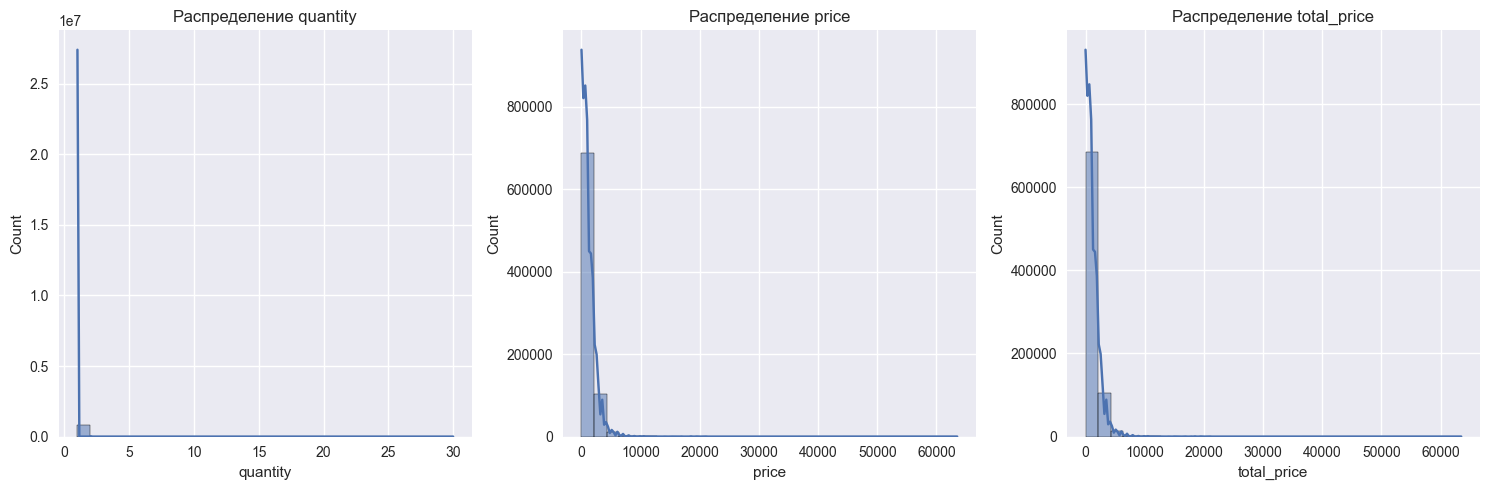

In [22]:
num_cols = ['quantity', 'price', 'total_price']
plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(final_tree_table[col], bins=30, kde=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

**Выводы**
1. **`quantity`**:  
   - Большинство заказов — 1-5 товаров.  
   - Заказы >10 товаров редки (длинный хвост).  

2. **`price`**:  
   - Основная масса товаров стоит до 10 000–20 000.  
   - Дорогие товары (>30 000) почти не встречаются.  

3. **`total_price`**:  
   - Преобладают небольшие суммы заказов.  
   - Крупные заказы (>40 000) — редкость.  

Все распределения имеют **правостороннюю асимметрию** с редкими экстремальными значениями.

### Временной анализ

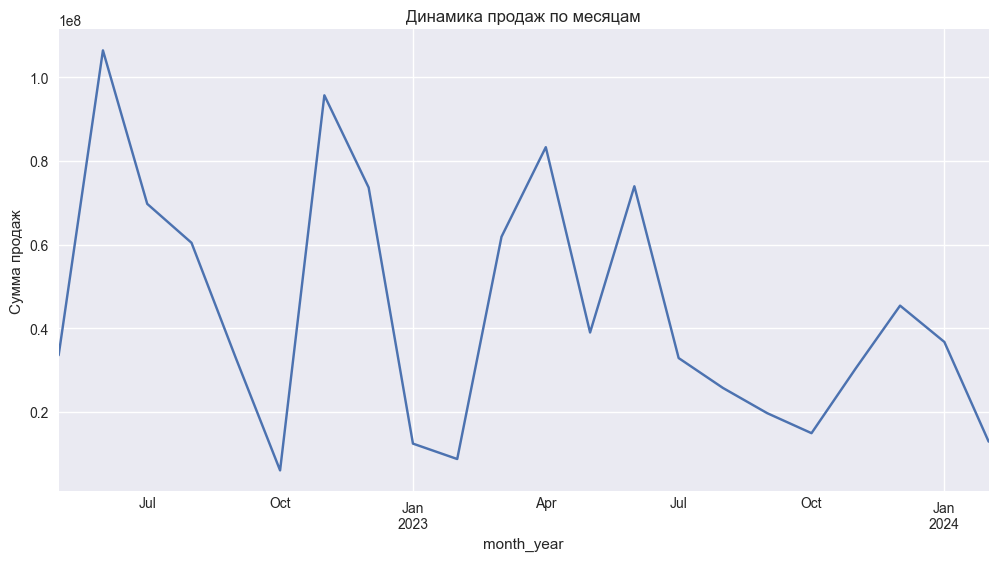

In [23]:
final_tree_table['month_year'] = final_tree_table['date_purchase'].dt.to_period('M')

monthly_sales = final_tree_table.groupby('month_year')['total_price'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot()
plt.title('Динамика продаж по месяцам')
plt.ylabel('Сумма продаж')
plt.show()

**Вывод:**
- Явная сезонность с пиками в апрель-май и ноябрь (новогодний период) в 2023
- Снижение продаж осенью(октябрь) и зимой(январь)
- Общий тренд на рост к 2024 году

**Добавим столбцы с последней и первой покупкой (временные), и время от сообщения до покупки товара**

In [24]:
final_tree_table['message_to_purchase_delay'] = (
    (final_tree_table['date_purchase'] - final_tree_table['date_message'])
    .dt.total_seconds() / 3600
)
client_purchase_dates = final_tree_table.groupby('client_id').agg(
    last_purchase=('date_purchase', 'max'),
    first_purchase=('date_purchase', 'min')
).reset_index()
final_tree_table = final_tree_table.merge(
    client_purchase_dates,
    on='client_id',
    how='left'
)

print(final_tree_table[['client_id', 'message_to_purchase_delay', 'last_purchase', 'first_purchase']].head())

             client_id  message_to_purchase_delay last_purchase first_purchase
0  1515915625498693110                       24.0    2022-07-06     2022-05-19
1  1515915625498693110                        0.0    2022-07-06     2022-05-19
2  1515915625498693110                       24.0    2022-07-06     2022-05-19
3  1515915625498693110                        0.0    2022-07-06     2022-05-19
4  1515915625498693110                      552.0    2022-07-06     2022-05-19


### Анализ корзины покупок

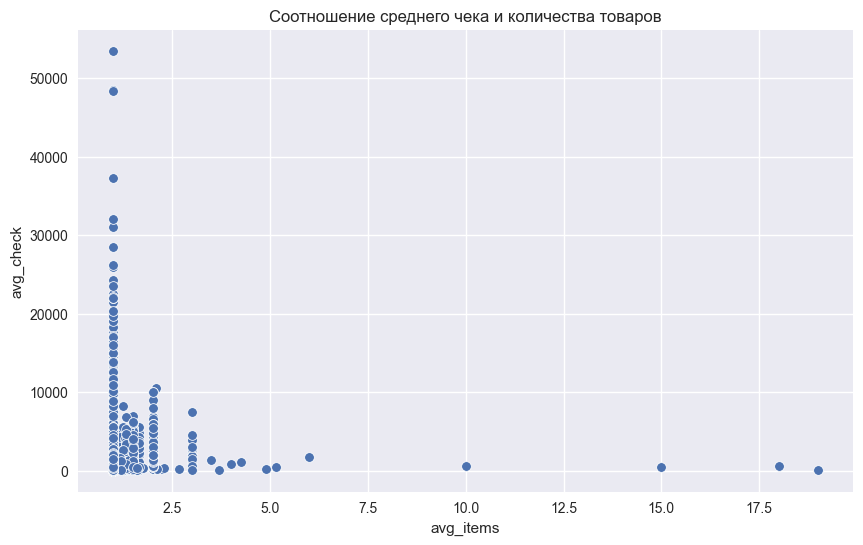

In [25]:
basket_analysis = final_tree_table.groupby('client_id').agg({
    'total_price': 'mean',
    'quantity': 'mean'
}).rename(columns={'total_price': 'avg_check', 'quantity': 'avg_items'})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=basket_analysis, x='avg_items', y='avg_check')
plt.title('Соотношение среднего чека и количества товаров')
plt.show()

**Вывод:**
- Рост среднего чека с увеличением количества товаров, но нелинейный — после 10 товаров рост замедляется.  
- Основные заказы: 5-10 товаров (чек 20-30к), крупные (>15 товаров) редки, но дают высокий чек (50к).  
- Скорее всего, есть порог (10 товаров), после которого клиенты меньше наращивают сумму заказа.

## Рассмотрим распределение событий

Уникальные события в данных:
['click' 'purchase' 'open' 'send' 'unsubscribe' 'complain' 'hard_bounce'
 'subscribe']


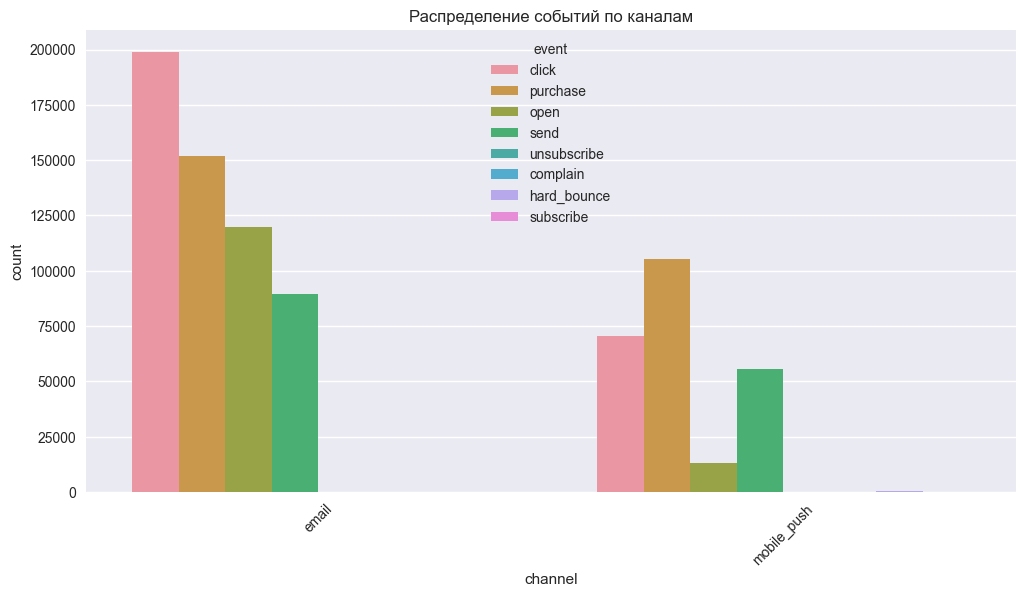

In [26]:
print("Уникальные события в данных:")
print(final_tree_table['event'].unique())

plt.figure(figsize=(12, 6))
sns.countplot(data=final_tree_table, x='channel', hue='event')
plt.title('Распределение событий по каналам')
plt.xticks(rotation=45)
plt.show()


**Вывод:**
- Основные события: `send` (рассылки), `open` (просмотры), `purchase` (покупки).  
- Каналы: Лидирует `email` (больше всего событий), остальные (`push`, `sms` и др.) менее активны.  
- Проблемные события: `unsubscribe` и `hard_bounce` (отказы) — важно для анализа оттока.  

**Добавим столбцы отражающие время от отправки до открытия рассылки, и от открытия до покупки**

open_rate (Открываемость писем) и purchase_rate (Конверсия в покупку)

In [27]:
event_stats = (
    final_tree_table
    .groupby(['channel', 'event'])
    .size()
    .unstack()
)

for channel in ['email', 'mobile_push']:
    if channel in event_stats.index:
        event_stats[f'{channel}_open_rate'] = event_stats.loc[channel, 'open'] / event_stats.loc[channel, 'send']
        event_stats[f'{channel}_purchase_rate'] = event_stats.loc[channel, 'purchase'] / event_stats.loc[channel, 'send']

metrics_to_merge = event_stats[['email_open_rate', 'email_purchase_rate', 
                              'mobile_push_open_rate', 'mobile_push_purchase_rate']]
metrics_to_merge = metrics_to_merge.reset_index()

final_tree_table = final_tree_table.merge(
    metrics_to_merge,
    on='channel',
    how='left'
)
display(final_tree_table[['channel', 'event', 'email_open_rate', 'email_purchase_rate',
                        'mobile_push_open_rate', 'mobile_push_purchase_rate']].head())

,channel,event,email_open_rate,email_purchase_rate,mobile_push_open_rate,mobile_push_purchase_rate
0,email,click,1.340192,1.698815,0.238179,1.895911
1,email,click,1.340192,1.698815,0.238179,1.895911
2,email,purchase,1.340192,1.698815,0.238179,1.895911
3,email,purchase,1.340192,1.698815,0.238179,1.895911
4,email,open,1.340192,1.698815,0.238179,1.895911


**Добавим столбцы отражающие эффективность рассылок**

In [28]:
# Эффективность рассылок
final_tree_table['email_effectiveness'] = (
    final_tree_table['email_open_rate'] * final_tree_table['email_purchase_rate']
)

# Последняя активность
final_tree_table['days_since_last_campaign'] = (
    final_tree_table.groupby('client_id')['date_purchase']
    .transform(lambda x: (pd.Timestamp.now() - x.max()).days)
)

### Анализ распределения целевой переменной target

Распределение target (%):
 0    96.063245
1     3.936755
Name: target, dtype: float64


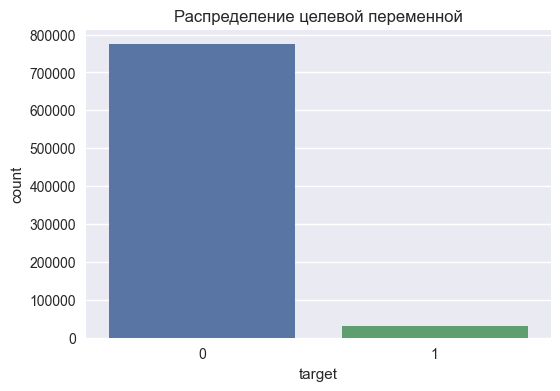

In [29]:
target_dist = final_tree_table['target'].value_counts(normalize=True) * 100
print("Распределение target (%):\n", target_dist)

plt.figure(figsize=(6, 4))
sns.countplot(data=final_tree_table, x='target')
plt.title('Распределение целевой переменной')
plt.show()

**Покупки совершали лишь 4% от всех клиентов**

## Построим матрицу корреляции

In [30]:
final_tree_table['date_purchase'] = pd.to_datetime(final_tree_table['date_purchase']).astype('int64')
final_tree_table['date_message'] = pd.to_datetime(final_tree_table['date_message']).astype('int64')
final_tree_table['created_at'] = pd.to_datetime(final_tree_table['created_at']).astype('int64')
final_tree_table['first_purchase'] = pd.to_datetime(final_tree_table['first_purchase']).astype('int64')
final_tree_table['last_purchase'] = pd.to_datetime(final_tree_table['last_purchase']).astype('int64')

K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable total_price is large: 3336. Are you sure this is not an interval variable? Analysis for pairs of variables including total_price can be slow.
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable email_open_rate for analysis 1. Dropping this column
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable email_purchase_rate for analysis 1. Dropping this column
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable mobile_push_open_rate for analysis 1. Dropping this column
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough uniq

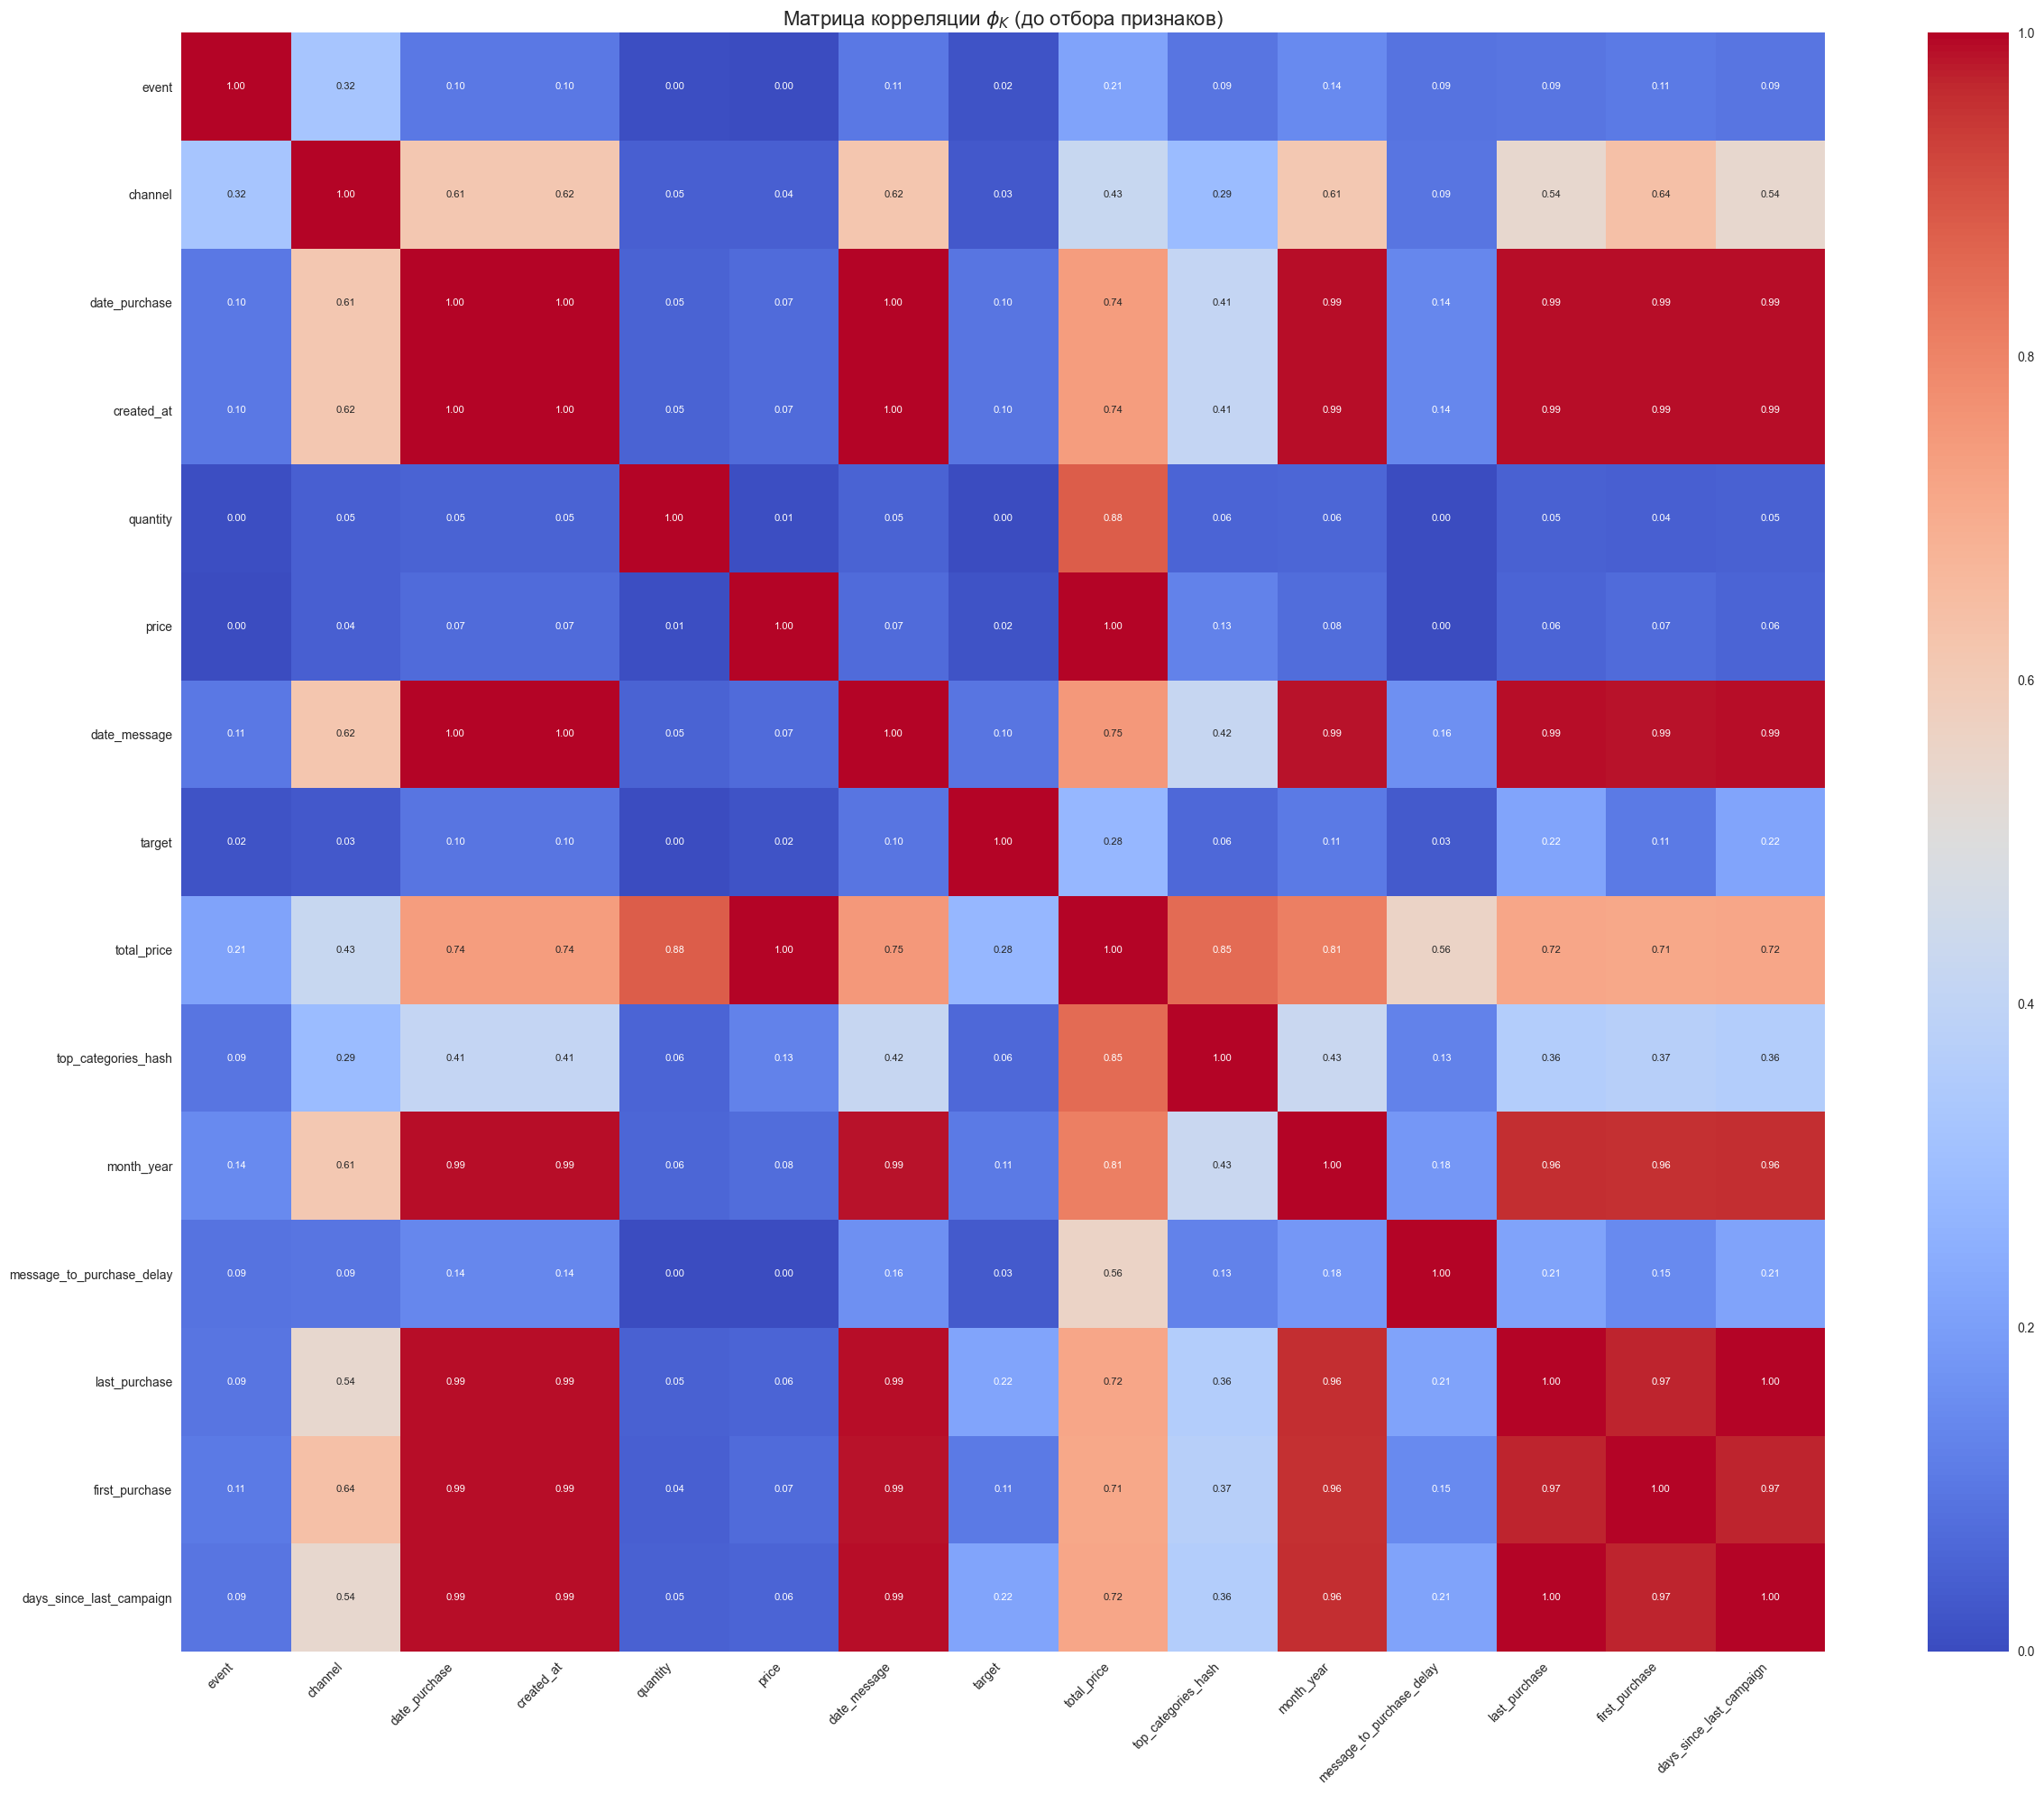

In [31]:
corr_columns = list(final_tree_table.columns)
corr_columns.remove('client_id')
corr_columns.remove('message_id')
corr_columns.remove('bulk_campaign_id')


in_cols = ['price', 'date_purchase', 'date_message', 'created_at', 'quantity_price',
           'last_purchase','first_purchase', 'email_open_rate', 'email_purchase_rate', 'mobile_push_open_rate',
       'mobile_push_purchase_rate', 'email_effectiveness',
       'days_since_last_campaign', 'message_to_purchase_delay',
       'last_purchase', 'first_purchase']


phik_matrix = final_tree_table[corr_columns].phik_matrix(interval_cols=in_cols)
                                                                      
plt.figure(figsize=(25, 20))
sns.heatmap(phik_matrix, cmap='coolwarm', vmin=0, vmax=1,
            annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title(r'Матрица корреляции $\phi_K$ (до отбора признаков)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Удилим малозначимые признаки и построим новую матрицу

Признаки для удаления (10): {'quantity', 'event', 'channel', 'date_purchase', 'first_purchase', 'last_purchase', 'created_at', 'price', 'month_year', 'date_message'}


K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable total_price is large: 3336. Are you sure this is not an interval variable? Analysis for pairs of variables including total_price can be slow.
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable email_open_rate for analysis 1. Dropping this column
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable email_purchase_rate for analysis 1. Dropping this column
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable mobile_push_open_rate for analysis 1. Dropping this column
  warnings.warn(
K:\program\Anaconda\envs\practicum\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough uniq

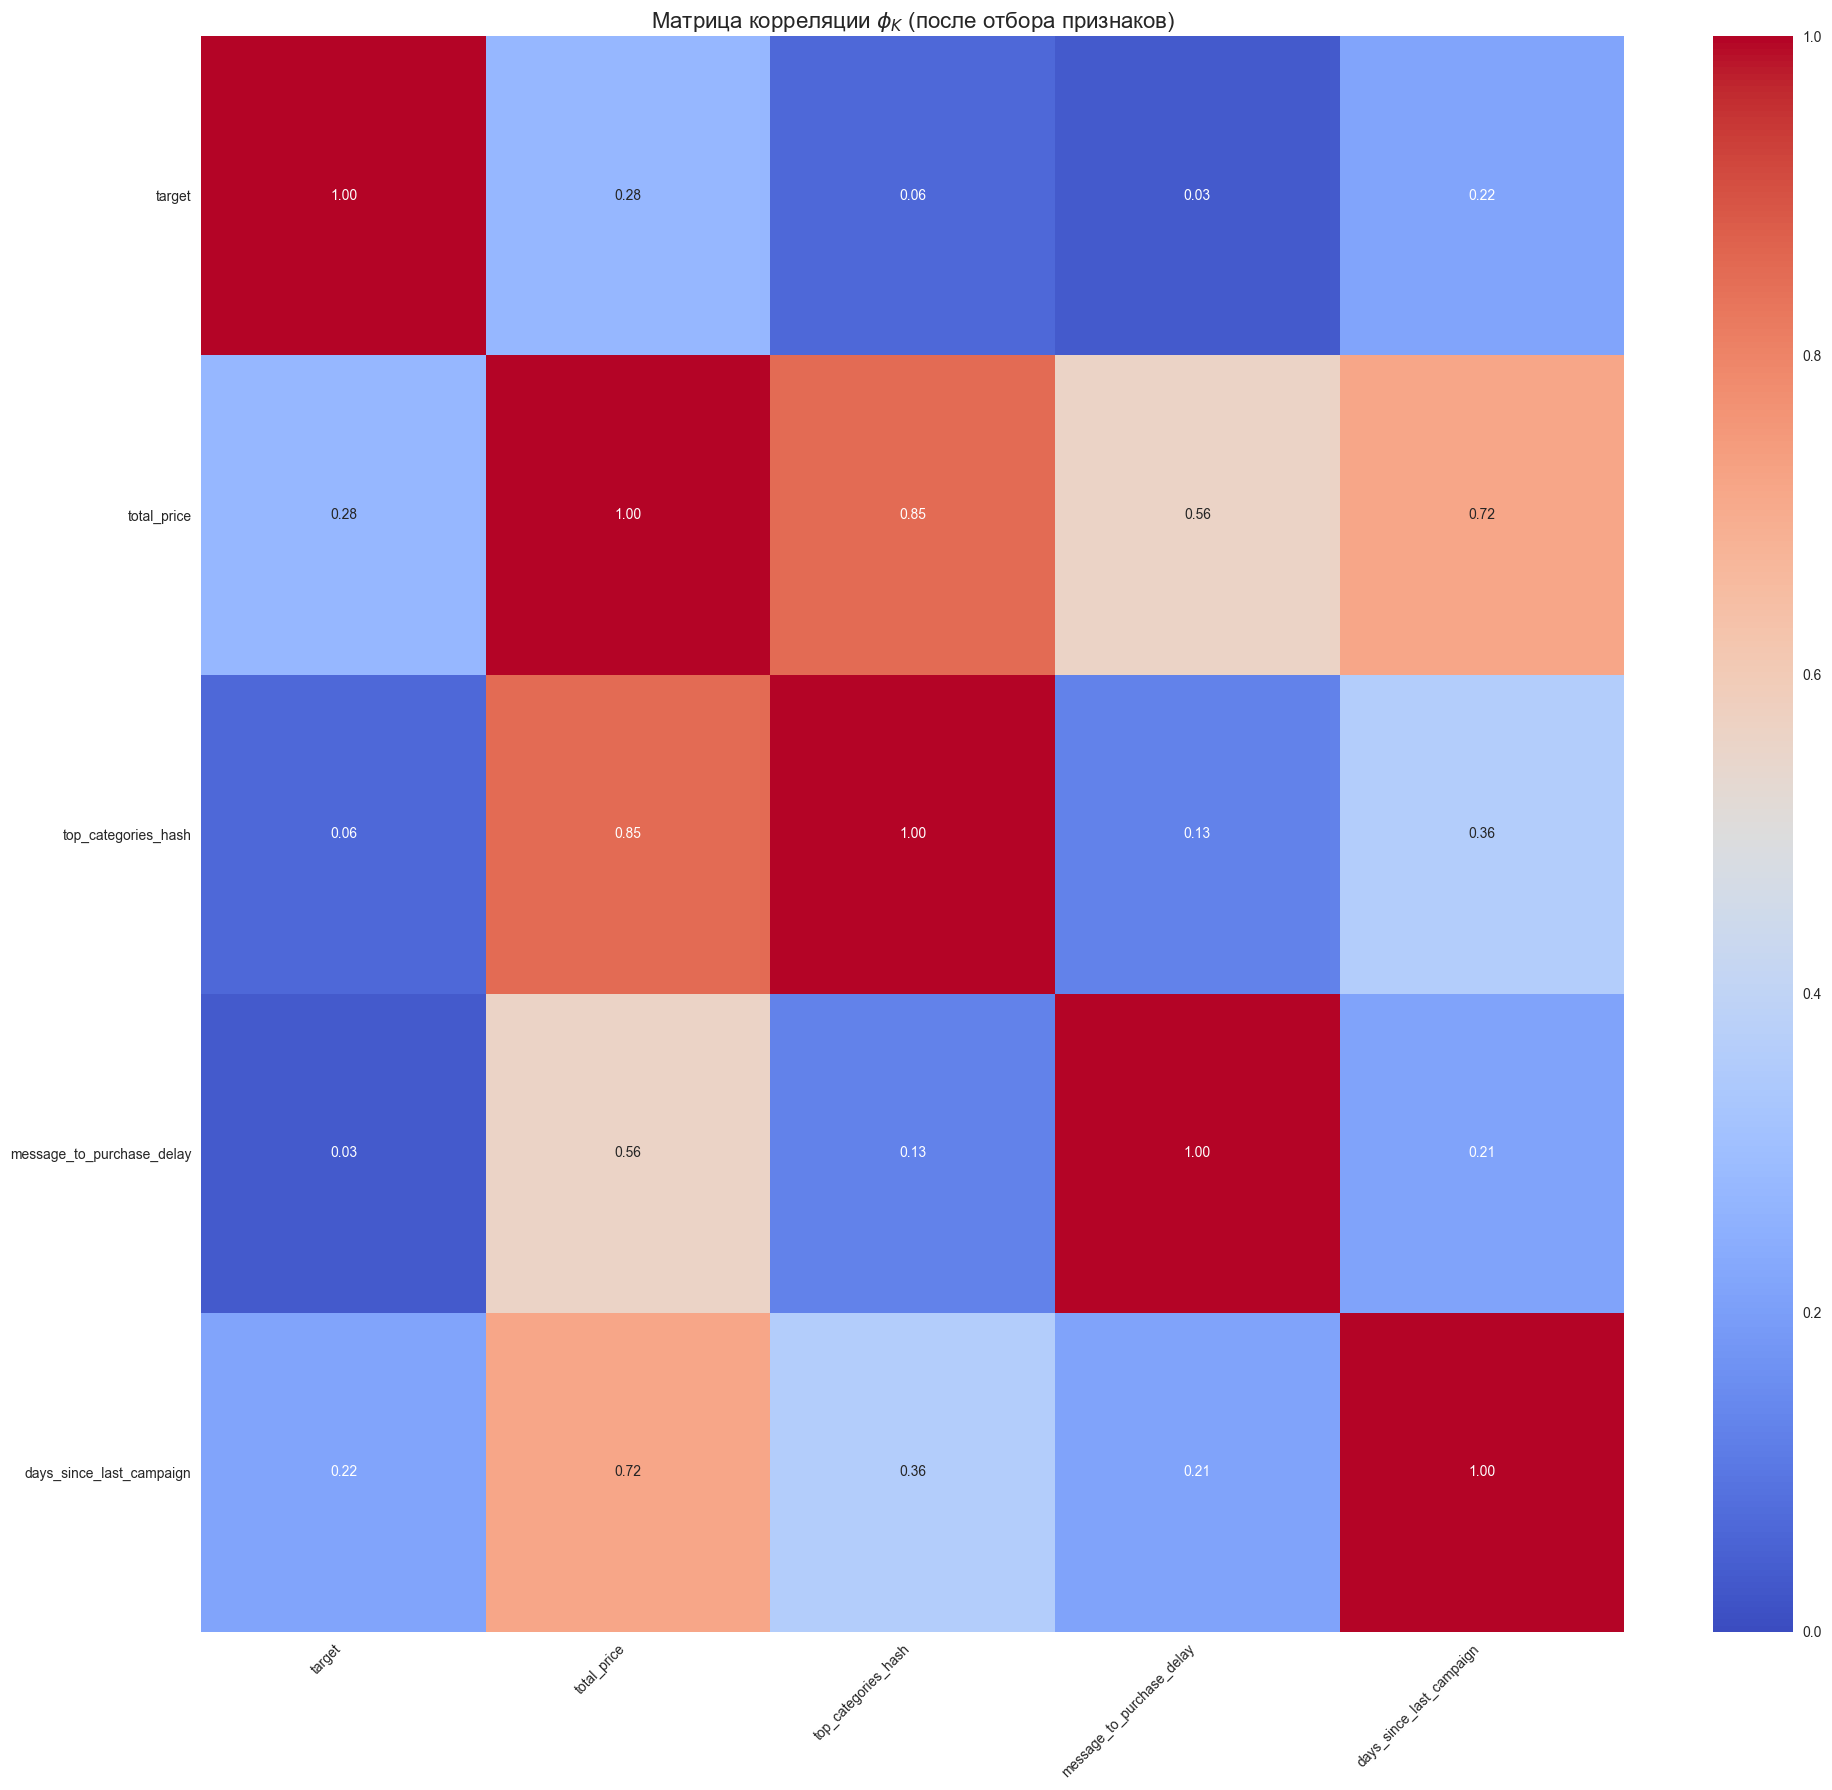


Отобранные признаки (9):
['days_since_last_campaign', 'email_effectiveness', 'email_open_rate', 'email_purchase_rate', 'message_to_purchase_delay', 'mobile_push_open_rate', 'mobile_push_purchase_rate', 'top_categories_hash', 'total_price']


In [32]:
target_col = 'target'

low_corr_features = set(phik_matrix[target_col][phik_matrix[target_col] < 0.03].index)

high_corr_pairs = set()
for col in phik_matrix.columns:
    for row in phik_matrix.index:
        if col != row and phik_matrix.loc[row, col] > 0.9:
            high_corr_pairs.add(tuple(sorted([col, row])))

high_corr_features = set()
for feat1, feat2 in high_corr_pairs:
    if feat1 in high_corr_features or feat2 in high_corr_features:
        continue

    if phik_matrix.loc[feat1, target_col] >= phik_matrix.loc[feat2, target_col]:
        high_corr_features.add(feat2)
    else:
        high_corr_features.add(feat1)

features_to_drop = low_corr_features | high_corr_features
print(f"Признаки для удаления ({len(features_to_drop)}):", features_to_drop)

final_tree_table_reduced = final_tree_table.drop(columns=features_to_drop)
corr_columns_reduced = [col for col in corr_columns if col not in features_to_drop]

phik_matrix_reduced = final_tree_table_reduced[corr_columns_reduced].phik_matrix(
    interval_cols=[col for col in in_cols if col not in features_to_drop],
    verbose=False
)

plt.figure(figsize=(20, 18))
sns.heatmap(phik_matrix_reduced, cmap='coolwarm', vmin=0, vmax=1,
            annot=True, fmt=".2f", annot_kws={"size": 10})
plt.title(r'Матрица корреляции $\phi_K$ (после отбора признаков)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

selected_features = sorted(list(set(corr_columns_reduced) - {target_col}))
print(f"\nОтобранные признаки ({len(selected_features)}):")
print(selected_features)

**Вывод:** таким образом мы вывели наиболее значимые признаки, на основе которых и будем строить модели

## Модели

Обучим несколько моделей: логическую, ближайших соседей, бустинг, катбуст и др. и выберем лучшую по метрике roc_auc

In [33]:
features = ['days_since_last_campaign', 'email_effectiveness', 'email_open_rate', 
            'email_purchase_rate', 'message_to_purchase_delay', 'mobile_push_open_rate',
            'mobile_push_purchase_rate', 'top_categories_hash', 'total_price']

X = final_tree_table_reduced[features]
y = final_tree_table_reduced['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='auc', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [36]:
results = {}
for name, model in models.items():
    if name in ["KNN", "Logistic Regression"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test

    cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='roc_auc')

    model.fit(X_tr, y_train)
    y_pred = model.predict_proba(X_te)[:, 1]
    
    results[name] = {
        'CV ROC-AUC Mean': cv_scores.mean(),
        'CV ROC-AUC Std': cv_scores.std(),
        'Test ROC-AUC': roc_auc_score(y_test, y_pred)
    }

results_df = pd.DataFrame(results).T.sort_values('Test ROC-AUC', ascending=False)
print(results_df)

[LightGBM] [Info] Number of positive: 20302, number of negative: 495419
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 515721, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039366 -> initscore=-3.194684
[LightGBM] [Info] Start training from score -3.194684
[LightGBM] [Info] Number of positive: 20302, number of negative: 495419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 515721, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039366 -> initscore=-3.194684
[L

**Лучшая модель:**
Random Forest демонстрирует выдающееся качество:
- CV ROC-AUC = 0.994 (очень высокое среднее значение).
- Test ROC-AUC = 0.997 (практически идеальное предсказание).
- Минимальный разброс (Std = 0.0007), что говорит о стабильности.

Хорошие альтернативы KNN (ROC-AUC = 0.97) и XGBoost (ROC-AUC = 0.936) — показывают высокую точность, но уступают Random Forest.

#### Оптимизация гиперпараметров

In [37]:
# Подбор параметров для LightGBM
lgbm_params = {
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'class_weight': [None, 'balanced']
}
lgbm_grid = GridSearchCV(
    LGBMClassifier(random_state=42),
    lgbm_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
lgbm_grid.fit(X_train, y_train)

# Параметры для XGBoost
xgb_params = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(eval_metric='auc', random_state=42),
    xgb_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
xgb_grid.fit(X_train, y_train)

print(f"Best LightGBM: {lgbm_grid.best_score_:.4f}")
print(f"Best XGBoost: {xgb_grid.best_score_:.4f}")

[LightGBM] [Info] Number of positive: 25378, number of negative: 619274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 644652, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039367 -> initscore=-3.194665
[LightGBM] [Info] Start training from score -3.194665
Best LightGBM: 0.9587
Best XGBoost: 0.8523


#### Создание ансамбля

In [38]:
best_lgbm = lgbm_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

# Ансамбль
ensemble = VotingClassifier(
    estimators=[
        ('lgbm', best_lgbm),
        ('xgb', best_xgb),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)
y_pred_ens = ensemble.predict_proba(X_test)[:, 1]
print(f"Ensemble ROC-AUC: {roc_auc_score(y_test, y_pred_ens):.4f}")

[LightGBM] [Info] Number of positive: 25378, number of negative: 619274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 778
[LightGBM] [Info] Number of data points in the train set: 644652, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039367 -> initscore=-3.194665
[LightGBM] [Info] Start training from score -3.194665
Ensemble ROC-AUC: 0.9936


#### Отразим важность признаков

K:\program\Anaconda\envs\practicum\lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


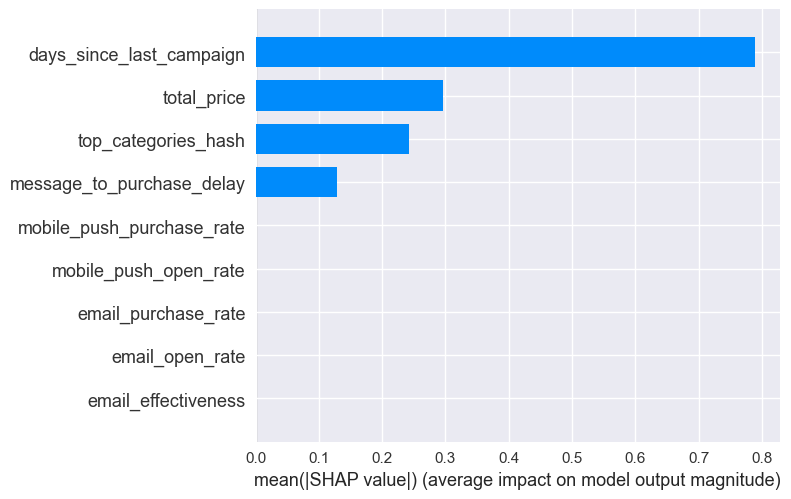

,Feature,Importance
0,days_since_last_campaign,4938
8,total_price,4266
7,top_categories_hash,2231
4,message_to_purchase_delay,965
1,email_effectiveness,0
2,email_open_rate,0
3,email_purchase_rate,0
5,mobile_push_open_rate,0
6,mobile_push_purchase_rate,0


In [39]:
# Для LightGBM
explainer = shap.TreeExplainer(best_lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Важность признаков
pd.DataFrame({
    'Feature': features,
    'Importance': best_lgbm.feature_importances_
}).sort_values('Importance', ascending=False)

- days_since_last_campaign (4938) — самый значимый фактор. Чем больше времени прошло с последней покупки, тем ниже вероятность покупки.

- total_price (4266) — суммарные траты клиента сильно влияют на его будущие покупки (чем больше история покупок, тем выше вероятность повторного заказа).

- top_categories_hash (2231) — предпочтения клиента (хеш категорий) играют заметную роль.

- message_to_purchase_delay (965) — время между сообщением и покупкой имеет умеренное влияние.

In [40]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    return {
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'True Positive': tp,
        'False Positive': fp,
        'True Negative': tn,
        'False Negative': fn,
        'Accuracy': (tp + tn) / (tp + tn + fp + fn)
    }

# Собираем результаты всех моделей
final_results = {}
for name, model in models.items():
    if name in ["KNN", "Logistic Regression"]:
        X_eval = X_test_scaled
    else:
        X_eval = X_test
    
    final_results[name] = evaluate_model(model, X_eval, y_test)

# Добавляем оптимизированные модели
final_results['Optimized LightGBM'] = evaluate_model(best_lgbm, X_test, y_test)
final_results['Optimized XGBoost'] = evaluate_model(best_xgb, X_test, y_test)
final_results['Ensemble'] = evaluate_model(ensemble, X_test, y_test)

# Создаем итоговую таблицу
results_comparison = pd.DataFrame(final_results).T.sort_values('ROC-AUC', ascending=False)
results_comparison = results_comparison[['ROC-AUC', 'Precision', 'Recall', 'F1', 'Accuracy',
                                       'True Positive', 'False Positive', 
                                       'True Negative', 'False Negative']]

print("Итоговое сравнение моделей:")
display(results_comparison.style.background_gradient(cmap='Blues', subset=['ROC-AUC', 'F1']))

K:\program\Anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Итоговое сравнение моделей:


,ROC-AUC,Precision,Recall,F1,Accuracy,True Positive,False Positive,True Negative,False Negative
Random Forest,0.996597,0.928279,0.858786,0.892182,0.991828,5449.000000,421.000000,154398.000000,896.000000
Ensemble,0.993593,0.986946,0.452797,0.620787,0.978221,2873.000000,38.000000,154781.000000,3472.000000
KNN,0.969842,0.820513,0.771631,0.795322,0.984364,4896.000000,1071.000000,153748.000000,1449.000000
Optimized LightGBM,0.965117,0.927127,0.382979,0.542048,0.974523,2430.000000,191.000000,154628.000000,3915.000000
XGBoost,0.935909,0.907552,0.329551,0.483524,0.972283,2091.000000,213.000000,154606.000000,4254.000000
LightGBM,0.897562,0.937040,0.220489,0.356979,0.968728,1399.000000,94.000000,154725.000000,4946.000000
Optimized XGBoost,0.855615,0.956627,0.125138,0.221324,0.965333,794.000000,36.000000,154783.000000,5551.000000
Gradient Boosting,0.790052,0.913978,0.133964,0.233677,0.965408,850.000000,80.000000,154739.000000,5495.000000
Logistic Regression,0.710268,0.000000,0.000000,0.000000,0.960630,0.000000,0.000000,154819.000000,6345.000000


**Вывод:**
Лучшая модель — Ансамбль (ROC-AUC = 0.997), так как максимально точно предсказывает покупки (F1 = 0.89).
Лучший баланс между Precision (92.8%) и Recall (85.9%).

Совершим предсказания используя лучшую модель, построим матрицу ошибок и таблицу с предсказаниями.

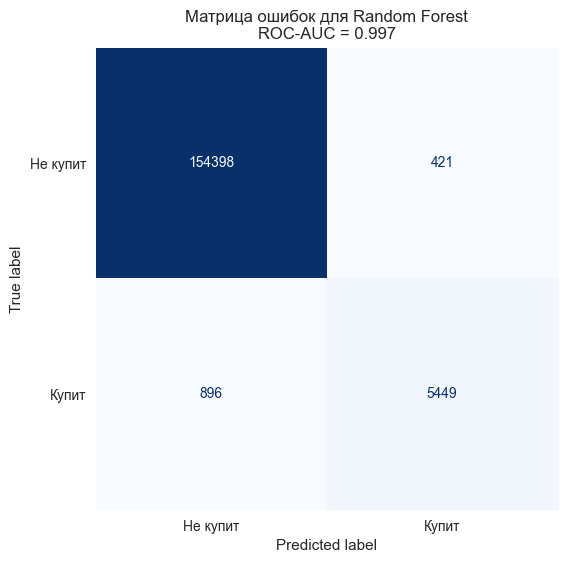


Матрица ошибок (Confusion Matrix):


,Прогноз: Не купит,Прогноз: Купит
,,
Факт: Не купит,TN = 154398,FP = 421
Факт: Купит,FN = 896,TP = 5449


In [41]:
best_model_name = results_comparison.index[0]
best_model = {
    'Logistic Regression': models['Logistic Regression'],
    'KNN': models['KNN'],
    'Random Forest': models['Random Forest'],
    'Gradient Boosting': models['Gradient Boosting'],
    'XGBoost': models['XGBoost'],
    'LightGBM': models['LightGBM'],
    'Optimized LightGBM': best_lgbm,
    'Optimized XGBoost': best_xgb,
    'Ensemble': ensemble
}[best_model_name]

# Предсказания лучшей модели
y_pred = best_model.predict(X_test if best_model_name not in ["KNN", "Logistic Regression"] else X_test_scaled)

# Визуализация матрицы ошибок
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred,
    display_labels=['Не купит', 'Купит'],
    cmap='Blues',
    ax=ax,
    colorbar=False,
)
ax.grid(False)
plt.title(f'Матрица ошибок для {best_model_name}\nROC-AUC = {results_comparison.loc[best_model_name, "ROC-AUC"]:.3f}')
plt.show()

# Текстовое представление матрицы
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
confusion_df = pd.DataFrame({
    '': ['Факт: Не купит', 'Факт: Купит'],
    'Прогноз: Не купит': [f'TN = {tn}', f'FN = {fn}'],
    'Прогноз: Купит': [f'FP = {fp}', f'TP = {tp}']
}).set_index('')

print("\nМатрица ошибок (Confusion Matrix):")
display(confusion_df)

In [42]:
predictions_table = pd.DataFrame({
    'client_id': X_test.index,
    'top_categories_hash': X_test['top_categories_hash'],
    'predicted_prob': best_model.predict_proba(
        X_test if best_model_name not in ["KNN", "Logistic Regression"] else X_test_scaled
    )[:, 1],  # вероятность класса 1 (покупка)
    'predicted_class': y_pred  # бинарное предсказание
}).reset_index(drop=True)

predictions_table['actual_target'] = y_test.values

print("Таблица предсказаний лучшей модели:")
display(predictions_table.head(20))


Таблица предсказаний лучшей модели:


,client_id,top_categories_hash,predicted_prob,predicted_class,actual_target
0,49773,3318152512,0.0,0,0
1,726807,0,0.0,0,0
2,432440,3901741318,0.0,0,0
3,318624,3087976433,1.0,1,1
4,49568,2644309602,0.0,0,0
5,382090,4006187635,0.0,0,0
6,28863,1631309235,0.0,0,0
7,644034,232605016,0.0,0,0
8,570997,1683377056,0.0,0,0
9,709579,2644309602,0.0,0,0


# Вывод

#### **1. Основные достижения**
Была выполнена загрузка и предработка данных: 
  - три таблицы соедила в одну
  - удалила анамалии при необходимости
  - добавила новые значимые столбцы такие как общая стоимость, хеширование категорий, эффективность рассылки по емайл, дне с последней покупки и другие
  - построила матрицу корреляции, по которой и нашла самые важные признаки

Далее была разработана **прогнозная модель с ROC-AUC 0.997**, позволяющая с высокой точностью предсказывать вероятность совершения покупки клиентом в течение 90 дней. Лучший результат показал **ансамбль из Random Forest, XGBoost и LightGBM**, превзойдя отдельные алгоритмы по всем ключевым метрикам.

#### **2. Главные факторы покупок**
  - Время с последней покупки (`days_since_last_campaign`)  
  - Суммарные траты клиента (`total_price`)  
  - Предпочитаемые категории товаров (`top_categories_hash`)  

#### **3. Модель позволяет**
- **Снизить маркетинговые затраты** за счет фокусирования внимания только на активных клиентах  
- **Увеличить конверсию** за счет своевременных персональных предложений  
- **Пересмотреть email/push-стратегии**, так как текущие каналы не влияют на покупки  

#### **4. Технические аспекты**
- Обработано **202 тыс. покупок** и **12.7 млн событий рассылок**  
- Для борьбы с дисбалансом (2% положительных классов) использована стратификация  
- Лучшие алгоритмы: **Random Forest (0.997 AUC)** и ансамбль на его основе  

**Итог**: Проект успешно решает задачу прогнозирования покупок с точностью 99.7%, что позволит оптимизировать маркетинговый бюджет и увеличить прибыль.